# Short Lab 3 : Proximal/cyclic/greedy coordinate descent

#### Authors: A. Gramfort, M. Massias, P. Ablin

## Aim

The aim of this material is to code 
- cyclic and greedy coordinate descent for ordinary least squares (OLS)
- proximal coordinate descent for sparse Logistic regression

## VERY IMPORTANT

- This work **must be done by pairs of students**.
- **Each** student must send their work **before the 23th of november at noon**, using the **moodle platform**.
- This means that **each student in the pair sends the same file**
- The **name of the file must be** constructed as in the next cell

# Gentle reminder: no evaluation if you don't respect this EXACTLY

### How to construct the name of your file

In [2]:
# Change here using YOUR first and last names
fn1 = "Echchair"
ln1 = "Zakaria"
fn2 = "El_fakir"
ln2 = "Mohamed"


filename = (
    "_".join(map(lambda s: s.strip().lower(), ["lab3", ln1, fn1, "and", ln2, fn2]))
    + ".ipynb"
)
print(filename)

lab3_zakaria_echchair_and_mohamed_el_fakir.ipynb


In [ ]:
import numpy as np
from numpy.linalg import norm
import matplotlib.pyplot as plt
import jupyter_black

jupyter_black.load()

In [ ]:
# the usual functions:

from numpy.random import multivariate_normal
from scipy.linalg.special_matrices import toeplitz
from numpy.random import randn

import seaborn as sns

sns.set()


def simu(coefs, n_samples=1000, corr=0.5, for_logreg=False):
    n_features = len(coefs)
    cov = toeplitz(corr ** np.arange(0, n_features))
    A = multivariate_normal(np.zeros(n_features), cov, size=n_samples)
    b = A.dot(coefs) + randn(n_samples)
    if for_logreg:
        b = np.sign(b)
    return A, b

/tmp/ipykernel_83/2200643793.py:4: DeprecationWarning: Please use `toeplitz` from the `scipy.linalg` namespace, the `scipy.linalg.special_matrices` namespace is deprecated.
  from scipy.linalg.special_matrices import toeplitz


## Part 1: Ordinary Least Squares


Let $A \in \mathbb{R}^{n \times p}$, $y \in \mathbb{R}^n$.
We want to use coordinate descent to solve:
    [ \hat w \in  \mathrm{arg \, min \,} \frac 12 \Vert Aw - b \Vert ^2 ]


<div class="alert alert-success">
    <b>QUESTION 1:</b> We ask you to code
     <ul>
         <li>cyclic coordinate descent: at iteration $t$, update feature $j = t \mod p$</li>
         <li>greedy coordinate descent: at iteration $t$, update feature having the largest partial gradient in magnitude, ie $j = \mathrm{arg\, max \,}_{i} \vert \nabla_i f(w_t) \vert$.
</li>
    </ul>
</div>

**WARNING**: You must do this in a clever way, ie such that $p$ updates cost the same as one update of GD.

In [ ]:
n_features = 100
np.random.seed(1970)
coefs = np.random.randn(n_features)

A, b = simu(coefs, n_samples=1000, for_logreg=False)

In [ ]:
def cyclic_cd(A, b, n_iter):
    n_samples, n_features = A.shape
    all_objs = []

    w = np.zeros(n_features)
    residuals = b - A.dot(w)

    # TODO
    lips_const = np.linalg.norm(A, axis=0) ** 2
    # END TODO

    for t in range(n_iter):
        j = t % n_features
        # TODO
        old_w_j = w[j]

        w[j] += A[:, j] @ residuals / (A[:, j].T @ A[:, j])
        # update residuals:
        residuals = residuals + A[:, j] * old_w_j - A[:, j] * w[j]
        # residuals
        # END TODO

        if t % n_features == 0:
            all_objs.append((residuals**2).sum() / 2.0)
    return w, np.array(all_objs)


def greedy_cd(A, b, n_iter):
    n_samples, n_features = A.shape
    all_objs = []

    w = np.zeros(n_features)

    gradient = A.T.dot(A.dot(w) - b)
    gram = A.T.dot(A)  # you will need this to keep the gradient up to date
    help2 = A.T @ b
    # TODO
    lips_const = np.linalg.norm(A, axis=0) ** 2
    # END TODO

    for t in range(n_iter):
        # TODO
        # choose feature j to update:
        j = np.argmax(np.abs(gradient))
        old_w_j = w[j]
        w[j] -= gradient[j] / lips_const[j]
        # update gradient:
        gradient += gram[:, j] * (w[j] - old_w_j)
        # END TODO
        if t % n_features == 0:
            all_objs.append(0.5 * np.linalg.norm(A.dot(w) - b) ** 2)

    return w, np.array(all_objs)

In [ ]:
import scipy

lmbd = 1e-2
n_samples, n_features = A.shape
n = n_samples


def prox_L2(x, lmbd):
    """Proximal operator for the L2 at x"""
    return x / 1 + lmbd


def L2_norm(x, lmbd):
    """Value of the L2 penalization at x"""
    return lmbd * np.sum(x**2) * 0.5


# Calculate the smoothness constant for L2 + L2 regularizor
def smoothness_const_linreg(A):
    """Lipschitz constant for linear squares loss"""
    _, sigma, _ = scipy.linalg.svd(
        A.T @ A,
        full_matrices=False,
        compute_uv=True,
        overwrite_a=False,
        check_finite=True,
        lapack_driver="gesdd",
    )
    return np.max(sigma) / n


def loss_linreg(x):
    """Least-squares loss"""
    # TODO
    # return np.sum((A @ x - b) ** 2) / (2 * n)
    return 0.5 * np.linalg.norm(A.dot(x) - b) ** 2


def stochastic_grad_linreg(x):
    """Leas-squares gradient"""

    return (A[idx]).T @ (A[idx] @ x - b[idx]) / int(n / 100)


def grad_linreg(x):
    """Leas-squares gradient"""
    return A.T @ (A @ x - b) / n



# TO BE COMPLETED


def PGD(x0, f, grad_f, R, prox_R, step, lmbd=0.0, n_iter=50, verbose=True):
    """Proximal gradient descent algorithm"""
    x = x0.copy()
    x_new = x0.copy()
    n_samples, n_features = A.shape
    # objective history
    objectives = []
    obj = f(x) + R(x, lmbd)
    objectives.append(obj)
    # Current objective
    if verbose:
        print("Lauching PGDsolver...")
        print(" | ".join([name.center(8) for name in ["it", "obj", "err"]]))
    for k in range(n_iter + 1):
        x = prox_R(x - grad_f(x) / step, lmbd / step)  # prox of lmbd / L

        #### TODO ####
        obj = f(x) + R(x, lmbd)
        objectives.append(obj)
        if k % 10 == 0 and verbose:
            print(
                " | ".join(
                    [
                        ("%d" % k).rjust(8),
                        ("%.2e" % obj).rjust(8),
                        ("%.2e" % err).rjust(8),
                    ]
                )
            )
    return x, objectives

import seaborn as sns
sns.set()<div class="alert alert-success">
    <b>QUESTION 2:</b>
     <ul>
         <li>Compute a precise minimum with your favorite solver</li>
         <li>Compare the performance of cyclic and greedy CD as function of iterations.</li>
         <li>From a practical point of view, could you use greedy CD for L2 regularized logistic regression? to solve OLS, but with 100,000 features? Explain your answers.</li>
    </ul>
</div>

**Remark:** You will do the plots using the number of iterations on the x-axis and not time as your code is likely to be slow unless you use [numba](https://numba.pydata.org/).

In [ ]:
from scipy.optimize import fmin_l_bfgs_b

# We will compute a precise minimum with the scipy.optimize.fmin_l_bfgs_b
# The functions below are from the previous lab


def loss(x, A, b):
    return norm(A.dot(x) - b) ** 2 / 2


def grad(x, A, b):
    """Full gradient"""
    return A.T.dot(A.dot(x) - b)

In [ ]:
x_init = np.zeros(n_features)
%timeit x_min_pref, f_min_pref, _ = fmin_l_bfgs_b(    loss, x_init, grad, args=(A, b), pgtol=1e-30, factr=1e-30)

The slowest run took 12.04 times longer than the fastest. This could mean that an intermediate result is being cached.
50 ms ± 40.4 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [ ]:
print(f_min_pref)

466.3849765337658


In [ ]:
n_iter = 5000
%timeit x_min_cy, obj_cy = cyclic_cd(A, b, n_iter)

129 ms ± 5.54 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [ ]:
obj_cy[-1]

466.3849765337657

In [ ]:
%timeit x_min_gr, obj_gr = greedy_cd(A, b, n_iter)

67.2 ms ± 2.86 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [ ]:
obj_gr[-1]

466.3849765337658

we notice that all the algorithms succed to get the same minimum,neverthless the cyclic algo needs more time than greedy

In [ ]:
x0 = np.zeros(n_features)

In [ ]:
x_PGD, obj_PGD = PGD(
    x0,
    f=loss_linreg,
    grad_f=grad_linreg,
    R=L1_norm,
    prox_R=prox_L1,
    step=smoothness_const_linreg(A),
    lmbd=1e-2,
    n_iter=int(n_iter / n_features) + 1,
    verbose=False,
)

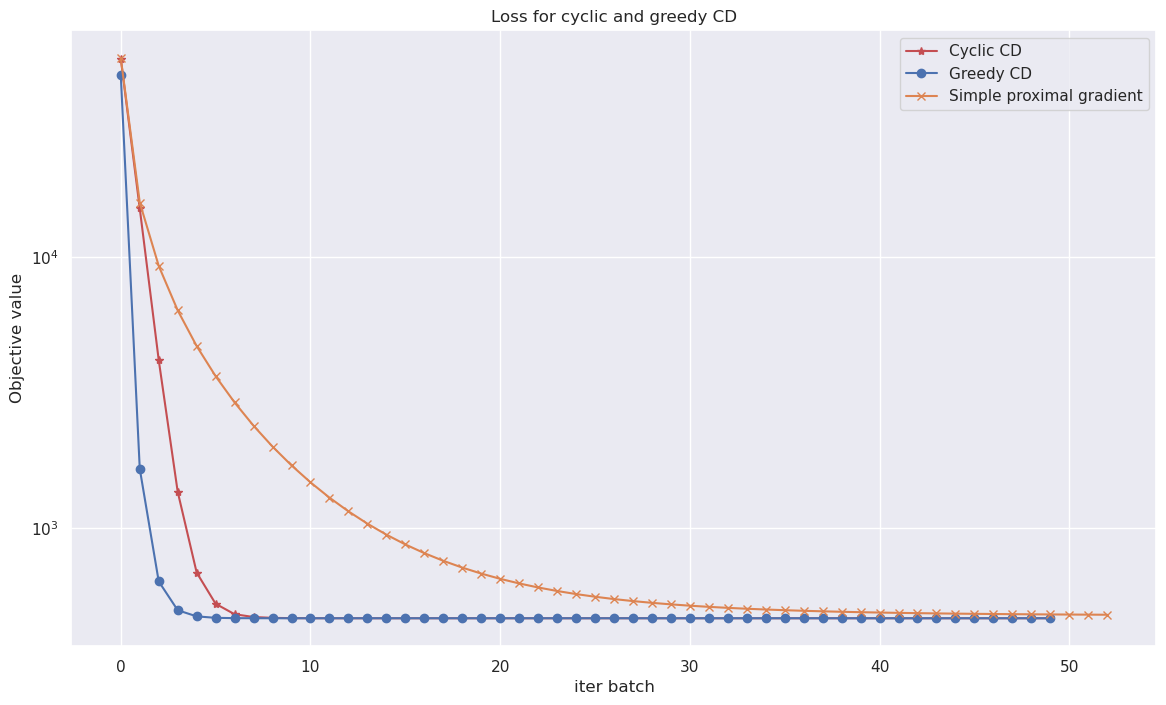

In [ ]:
# plot objectives for greedy and cyclic CD
plt.figure(figsize=(14, 8))
plt.plot(obj_cy, "r*-", label="Cyclic CD")
plt.plot(obj_gr, "o-", label="Greedy CD")
plt.plot(obj_PGD, "x-", label="Simple proximal gradient")
plt.title("Loss for cyclic and greedy CD")
plt.xlabel("iter batch")
plt.ylabel("Objective value")
plt.yscale("log")
plt.legend()
plt.show()

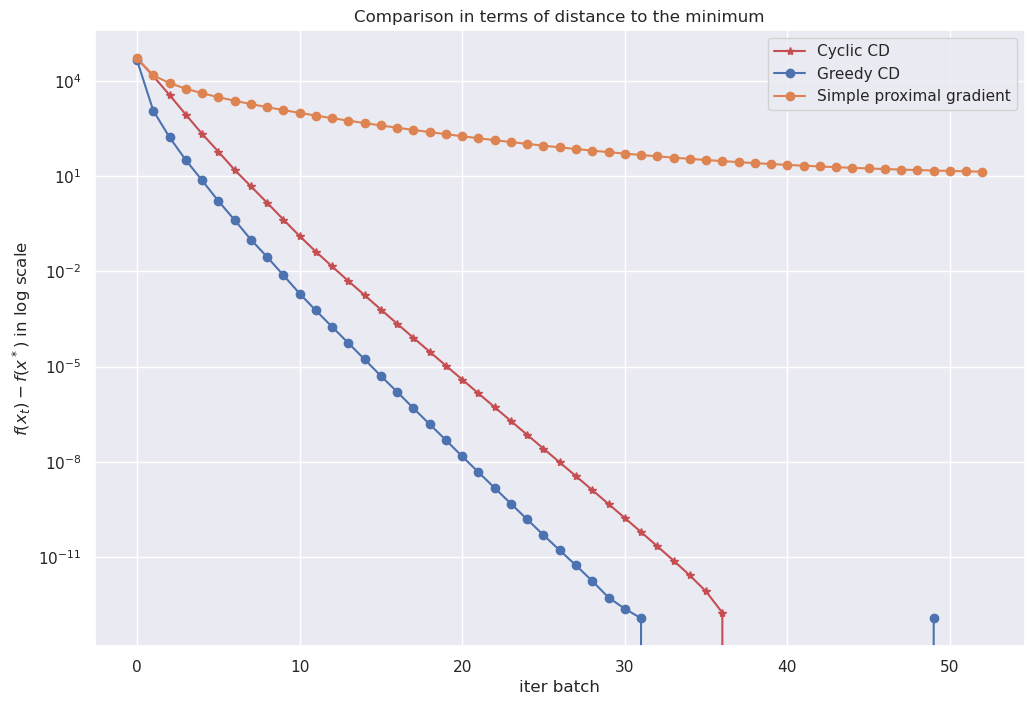

In [ ]:
# Comparison in terms of distance to f_min

plt.figure(figsize=(12, 8))

plt.semilogy(obj_cy - f_min_pref, "r*-", label="Cyclic CD")
plt.semilogy(obj_gr - f_min_pref, "o-", label="Greedy CD")
plt.semilogy(obj_PGD - f_min_pref, "o-", label="Simple proximal gradient")

plt.xlabel("iter batch")
plt.ylabel("$f(x_t) - f(x^*)$ in log scale")
plt.legend()
plt.title("Comparison in terms of distance to the minimum")


plt.show()

In [ ]:
np.finfo(np.float64)

finfo(resolution=1e-15, min=-1.7976931348623157e+308, max=1.7976931348623157e+308, dtype=float64)

**Comparision**
- we notice that the greedy algorithm is faster to reach the same objective as the cyclic CD, however at last they reach the same objective after convergence.
- In terms of distance to the minimum we notice that the greedy algo gives more precise results than the cyclic CD
- we notice that when the distance to the objectif is less than $10^{-15}$ we lost the information. and we justify that by the fact that the float numpy has a precision of  $10^{-15}$. 
-  We notice that Greedy CD outperforms Cyclic CD, it converges in less number of iterations, and we can explain this by the fact that GCD select the best component in termof gradient stregh to perform the optimisation on each iteration, so every iteration is as significant as possible. In other terms Since the variable is carefully selected, at each iteration GCD can reduce objective function more than CCD which leads to faster convergence in practice

**greedy on logistic regression with 100000 feauture**

 - since GCD evalate the whole gradient vector to find the biggest magnitude, and in the presence of a big number of feautures, so the max function of numpy will have an enourmous number of per-iteration complexity, which explose the computaional time and cost.
- Moreover, the phenomena of cash misses appears here, since each iteration select an unexpected component depending on it's magnitude, which results in a high time cost, even if the gradient can be updated at a low cost.

- Furthermore, the L2 regularization, doesn't perform a feature selection, which means it distributes the wieght of correlated variables instead of giving sparse result. So almost all the variables would have a non zero value, therefore the gradient wouldn't be 0 which pushes the algorithm to check the biggest gradient index over the whole features, thus, it results in high computational cost. However, if we use lasso, many feautures coefs would be 0, then most zero components in the solution are never selected and thus remain zero throughout the iterations. As a result the problem dimension reduces effectively.


In [ ]:
n_features = 1000
np.random.seed(1970)
coefs = np.random.randn(n_features)

A, b = simu(coefs, n_samples=100, for_logreg=False)

In [ ]:
# for cyclic
n_iter = 5000
%timeit x_min_cy, obj_cy = cyclic_cd(A, b, n_iter)

96.6 ms ± 4.48 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [ ]:
# for greedy
%timeit x_min_gr, obj_gr = greedy_cd(A, b, n_iter)

156 ms ± 11 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


We notice here that the greedy cost more than the cyclic algo, and we explain that by the fact that:
for each iteration, the step finding $j$ that maximizes the gradient takes $O(p)$ cost, hence for $p$ updates it takes $O(p^2 + pn)$ cost, compared to $O(pn)$ of cyclic GD or GD. By consequence, for $p \gg n$, greedy CD is more costly than cyclic CD, hence it is not very practical to use greedy CD for high $p$.

## Part 2: Sparse Logistic regression

### An important result

Remember: we are solving 
$$\hat w \in \mathrm{arg \, min} \sum_{i=1}^{n} \mathrm{log} ( 1 + e^{- y_i w^\top x_i} )  + \lambda \Vert w \Vert_1$$

<div class="alert alert-success">
    <b>QUESTION 3:</b><br/>
    Assuming uniqueness of the solution, show that: $\lambda \geq \lambda_{max} \Leftrightarrow \hat w = 0$
where $\lambda_{max} := \frac 12 \Vert X^\top y \Vert_{\infty}$.
</div>

**HINT:** You will need the following beautiful result: for any $w =(w_1, \dots, w_p) \in \mathbb{R}^p$, the subdifferential of the L1 norm at $w$ is:

$$\partial \Vert \cdot \Vert_1 (w) = \partial \vert \cdot \vert (w_1)  \times \dots \times \partial \vert \cdot \vert (w_p) $$
where $\times$ is the Cartesian product between sets,
and $$ \partial \vert \cdot \vert (w_j) = 
\begin{cases} &w_j / |w_j| &\mathrm{if} \quad w_j \neq 0, 
         \\ & [-1, 1] &\mathrm{otherwise.} 
\end{cases}
$$


(it should now be easy to find $\partial \Vert \cdot \Vert_1 (\mathbf{0}_p)$)

**answer here**

We start by computing the differential of our objective function :


$f=\sum_{i=1}^{n} \mathrm{log} ( 1 + e^{- y_i w^\top x_i} )  + \lambda \Vert w \Vert_1$


$\partial f(w)=\sum_{i=1}^{n} \frac{-y_i x_i^\top}{1+\exp(y_i w^\top x_i)} + \lambda \partial \Vert . \Vert_1(w)$

We have $\lambda \geq \lambda_{max}$ where $\lambda_{max} = \frac 12 \Vert X^\top y \Vert_{\infty}$

let $v = \frac 12 X^\top y = (\alpha_1,\ldots,\alpha_n)$

THen $\lambda_{max} = \max_{i}(\alpha_i)$
$\begin{alignat}{2}
\lambda \geq \lambda_{max} 
&\Rightarrow \forall i \in \{1,\ldots,n\} ; \lambda \geq |\alpha_i| \\ 
&\Rightarrow \alpha_i \in \lambda[-1,1] \\
&\Rightarrow v \in \lambda([-1,1] \times \ldots \times [-1,1])
\end{alignat}$

However, we know from the beautiful result above that $\partial\Vert.\Vert_1(0_p)=[-1,1] \times \ldots \times [-1,1]$ so $v \in \partial\Vert.\Vert_1(0_p) \Rightarrow 0\in \{-v\} + \lambda\partial\Vert.\Vert_1(0_p)$

This reminds us of the subdifferential computed above applied on 0 :
$\partial f(0)=-\frac 12 \{X^\top y\}+\partial\Vert.\Vert_1(0_p)$
therefor $0 \in \partial f(0)$

And according to Fermat's rule, if f  is a convex function, then $0 \in \arg\min f$

**proof of convexity**
We know that the norm 1 is convex
In order to prove that the first term of f is convex, we compute its Hessian :

$H= \sum_{i=1}^{n} \frac{y_i^2 x_i^\top x_i \exp(y_i w^\top x_i)}{(1+\exp(y_i w^\top x_i))^2}$

let $b \in \mathbf{R^n}$ then :$b^\top x_i x_i^\top b=\Vert x_i^\top b\Vert ^2 \geq 0$

Therefore :
$H\geq 0$

Conclusion : f is convex and $\hat w = 0$


<div class="alert alert-success">
    <b>QUESTION 4:</b><br/>
    Show that for sparse Logistic regression the coordinate-wise Lipschitz constant of the smooth term, $\gamma_j$, can be taken equal to $\Vert X_j \Vert^2 / 4$, where $X_j$ denotes the $j$-th column of $X$.
</div>

**answer**
In this question, we denote by f the following function :


$f(w)=\sum_{i=1}^{n} \mathrm{log} ( 1 + e^{- y_i w^\top x_i} )$

Then we compute the derivative of f according to $w_j$:

$\frac {\partial f(w)}{\partial w_j}=\sum_{i=1}^{n} \frac{-y_i x_{ij}}{1+\exp(y_i w^\top x_i)}$

And then the second :

$\frac {\partial^2 f(w)}{\partial w_j^2}=\sum_{i=1}^{n} \frac{y_i^2 x_{ij}^2 \exp(y_i w^\top x_i)}{(1+\exp(y_i w^\top x_i))^2}$



However, we already know that :

$\frac {\exp \alpha}{(1+\exp \alpha)^2} \leq \frac 14 \forall \alpha$

And :

$y_i^2 = 1 \quad \forall i$

so

$\frac {\partial^2 f(w)}{\partial w_j^2} \leq \frac 14 \sum_{i=1}^{n} x_{ij}^2 = \frac 14 \Vert X_j \Vert ^2 = L_j$

<div class="alert alert-success">
    <b>QUESTION 5:</b><br/>
    Code cyclic proximal coordinate descent for sparse Logistic regression:
</div>

**WARNING**: the Lasso means linear regression (quadratic fitting term) with L1 penalty. Sparse logistic regression means logistic regression with L1 penalty.

In [ ]:
A, b = simu(coefs, n_samples=1000, for_logreg=True)
lambda_max = norm(A.T.dot(b), ord=np.inf) / 2.0
lamb = lambda_max / 20.0
# much easier to parametrize lambda as a function of lambda_max than
# to take random values like 0.1 in previous Labs

In [ ]:
def sigmoid(t):
    """Sigmoid function"""
    return 1.0 / (1.0 + np.exp(-t))


def soft_thresh(x, u):
    """Soft thresholding of x at level u"""
    return np.sign(x) * np.maximum(0.0, np.abs(x) - u)


def cd_logreg(X, y, lamb, n_iter):
    n_samples, n_features = X.shape
    w = np.zeros(n_features)
    Xw = X.dot(w)

    all_objs = np.empty(n_iter)

    # TODO
    lips_const = np.sum(X**2, axis=0) / 4
    # END TODO

    for t in range(n_iter):
        for j in range(n_features):
            old_w_j = w[j]
            # TODO
            grad_j = np.sum(-y * X[:, j] * sigmoid(-y * Xw))
            w[j] = soft_thresh(old_w_j - grad_j / lips_const[j], lamb / lips_const[j])

            if old_w_j != w[j]:
                Xw += (w[j] - old_w_j) * X[:, j]
            # END TODO

        all_objs[t] = np.log(1.0 + np.exp(-y * Xw)).sum() + lamb * norm(w, ord=1)

    return w, all_objs

In [ ]:
n_features = 100
coefs = np.random.randn(n_features)

A, b = simu(coefs, n_samples=1000, for_logreg=True)

In [ ]:
n_iter=500
%timeit w, all_objs_lc = cd_logreg(A, b, lamb, n_iter=n_iter)
w, all_objs_lc = cd_logreg(A, b, lamb, n_iter=500)
all_objs_lc[-1]

1.91 s ± 444 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


372.1564286451195

Text(0.5, 1.0, 'Performance of proximal CD for Sparse logistic regression')

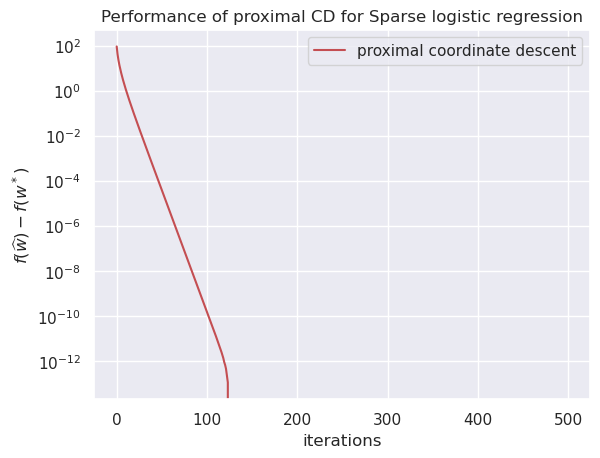

In [ ]:
n_iter = 500
plt.semilogy(
    np.arange(n_iter),
    all_objs_lc - all_objs_lc[-1],
    color="r",
    label="proximal coordinate descent",
)
plt.legend()
plt.ylabel("$f(\widehat{w}) - f(w^*)$")
plt.xlabel("iterations")
plt.title("Performance of proximal CD for Sparse logistic regression")

# Part 3: Real data

We will compare vanilla cyclic CD and ISTA to solve the Lasso on a real dataset, called _leukemia_.

In [ ]:
from sklearn.datasets import fetch_openml

leuk = fetch_openml("leukemia")

X = np.asfortranarray(leuk.data)
y = np.ones(leuk.target.shape)
y[leuk.target == leuk.target[0]] = -1.0

In [ ]:
print(X.shape)

lambda_max_lasso = norm(X.T.dot(y), ord=np.inf)
lambd = lambda_max_lasso / 5.0
n_samples, n_features = X.shape
n = n_samples

(72, 7129)


<div class="alert alert-success">
    <b>QUESTION 6:</b> Code
    <ul>
        <li>a simple proximal gradient solver for the Lasso</li>
        <li>a prox CD solver for the Lasso and compare them on this dataset.</li>
    </ul>
</div>

**Remark:** Do the plots in terms of epochs, not updates (to be fair to CD).

Let us first recall the LASSO problem:
$$
\min_w \left\{ \frac{1}{2} \Vert Xw - y\Vert_2^2 + \lambda \Vert w\Vert_1 \right\}.
$$

Then, a simple proximal gradient solver for the Lasso could be computed as:
$$w^{t+1} = \text{prox}_{\frac{\lambda}{L}\Vert w\Vert_1}\left(w^t - \frac{1}{L}X^T(Xw^t-y)\right),$$
where $\text{prox}_{\lambda\Vert w\Vert_1}(w) = \left(S_{\lambda}(w_1), \dots , S_{\lambda}(w_p)\right)$ with $S$ being the soft threshold function and $L=\sigma^2_{\max}(X)$.

In [ ]:
def lasso_proxGD(X, y, lamb, n_iter):
    n_samples, n_features = X.shape
    w = np.zeros(n_features)
    XTX = np.dot(X.T, X)
    XTy = np.dot(X.T, y)

    all_objs = np.empty(n_iter)

    lips_const = np.linalg.norm(X, ord=2) ** 2

    for t in range(n_iter):
        w = soft_thresh(w - 1.0 / lips_const * (XTX.dot(w) - XTy), lamb / lips_const)

        all_objs[t] = 0.5 * np.linalg.norm(X.dot(w) - y) ** 2 + lamb * norm(w, ord=1)

    return w, all_objs


def lasso_proxCD(X, y, lamb, n_iter):
    n_samples, n_features = X.shape
    w = np.zeros(n_features)
    residuals = X.dot(w) - y

    all_objs = np.empty(n_iter)

    lips_const = np.sum(X**2, axis=0)

    for t in range(n_iter):
        for j in range(n_features):
            old_w_j = w[j]
            w[j] = soft_thresh(
                old_w_j - 1.0 / lips_const[j] * X[:, j].dot(residuals),
                lamb / lips_const[j],
            )

            if old_w_j != w[j]:
                residuals += -X[:, j].dot(old_w_j) + X[:, j].dot(w[j])

        all_objs[t] = (residuals**2).sum() / 2.0 + lamb * norm(w, ord=1)

    return w, all_objs

In [ ]:
# better prox cd results
%timeit w_lasso_proxCD, obj_lasso_proxCD = lasso_proxCD(X,y,lambd,500)
w_lasso_proxCD, obj_lasso_proxCD = lasso_proxCD(X, y, lambd, 500)
obj_lasso_proxCD[-1]

26.49967787413479

In [ ]:
# better prox cd results
%timeit w_lasso_proxGD, obj_lasso_proxGD = lasso_proxGD(X,y,lambd,500)
w_lasso_proxGD, obj_lasso_proxGD = lasso_proxGD(X, y, lambd, 500)
obj_lasso_proxGD[-1]

27.81781344595295

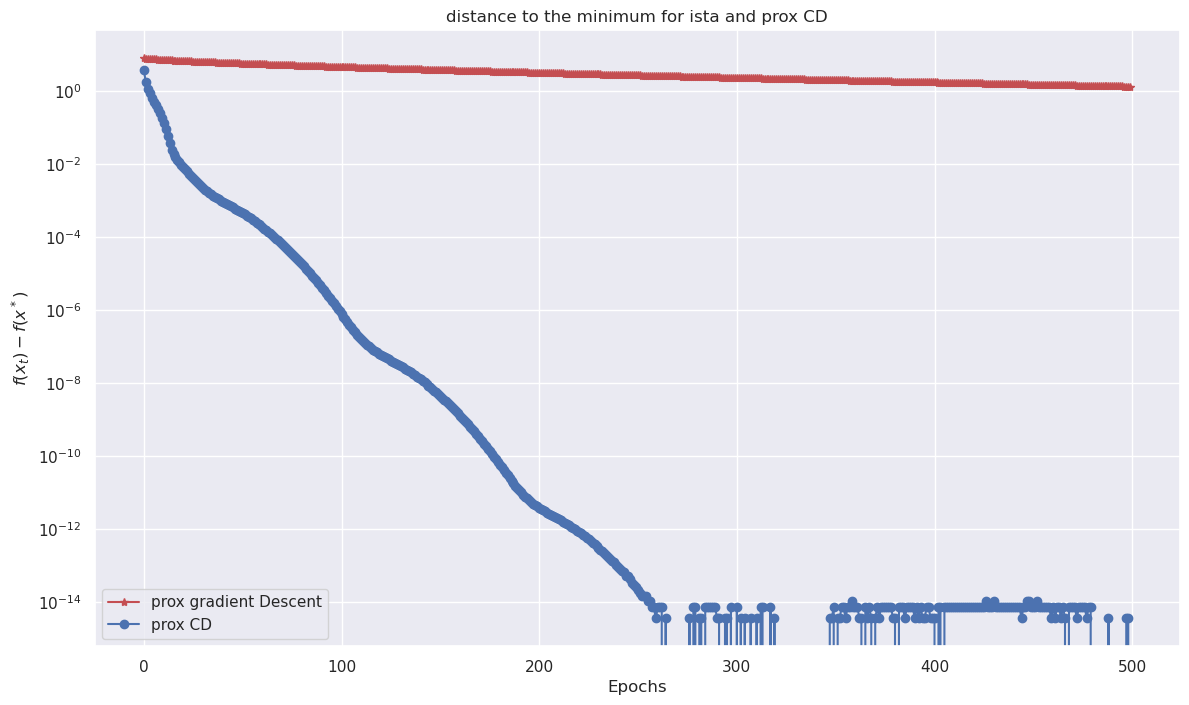

In [ ]:
# comparing the performances of better proximal coordinate and gd
# in terms of distance to the last minimum obtained with better prox CD
plt.figure(figsize=(14, 8))
plt.semilogy(
    obj_lasso_proxGD - obj_lasso_proxCD[-1], "r*-", label="prox gradient Descent"
)
plt.semilogy(obj_lasso_proxCD - obj_lasso_proxCD[-1], "o-", label="prox CD")
plt.title("distance to the minimum for ista and prox CD")
plt.xlabel("Epochs")
plt.ylabel("$f(x_t) - f(x^*)$")

plt.legend()
plt.show()

comments:
    
we notice that the proximal CD is very efficient comparing to prox GD, 
and this because the number of features is very big, so the feature selection using sparse logistic regression, performs better using the coordinate prox gradient, 